In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, plot_confusion_matrix
pd.options.display.width = 0
pd.options.display.max_rows = None
pd.options.display.float_format = "{:.2f}".format

**The task consists in identify true and fake news.**

I will work with CountVectorizer and Logistic Regression. In case Logistic Regression shouldn't provide good enough results I will check other models. I will try to automize the process with ColumnTransformer and Pipeline.

In [3]:
data_true = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
data_fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")

In [4]:
data_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Adding label feature for true news:

In [5]:
data_true['true0_fake1'] = 0
data_true.head()

,title,text,subject,date,true0_fake1
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [6]:
data_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        21417 non-null  object
 1   text         21417 non-null  object
 2   subject      21417 non-null  object
 3   date         21417 non-null  object
 4   true0_fake1  21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.7+ KB


In [7]:
data_true['subject'].unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [8]:
data_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Adding label feature for fake news:

In [9]:
data_fake['true0_fake1'] = 1
data_fake.head()

,title,text,subject,date,true0_fake1
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [10]:
data_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        23481 non-null  object
 1   text         23481 non-null  object
 2   subject      23481 non-null  object
 3   date         23481 non-null  object
 4   true0_fake1  23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB


In [11]:
data_fake['subject'].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

Merging both data sets (True and fake):

In [12]:
frames = [data_true, data_fake]
data = pd.concat(frames, sort=False).reset_index()

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        44898 non-null  int64 
 1   title        44898 non-null  object
 2   text         44898 non-null  object
 3   subject      44898 non-null  object
 4   date         44898 non-null  object
 5   true0_fake1  44898 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.1+ MB


In the process of getting Unix date I discovered some not correct data in feature 'date'. I will remove them:

In [14]:
data = data.drop(data[data['date'].str.startswith('htt')].index)

In [15]:
date_error = data[data['date'].str.startswith('htt')]
date_error

,index,title,text,subject,date,true0_fake1


In [16]:
data = data.drop(data[data['date'].str.startswith('MS')].index)

In [17]:
date_error_1 = data[data['date'].str.startswith('MS')]
date_error_1

,index,title,text,subject,date,true0_fake1


After cleaning feature 'date' all is ready to compute to_datetime and and Timestamp (Unix date):

In [18]:
data['new_date'] = pd.to_datetime(data['date'],infer_datetime_format=True)

In [19]:
data['unix_date'] = (data['new_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [20]:
data.head()

,index,title,text,subject,date,true0_fake1,new_date,unix_date
0,0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0,2017-12-31,1514678400
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0,2017-12-29,1514505600
2,2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0,2017-12-31,1514678400
3,3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0,2017-12-30,1514592000
4,4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0,2017-12-29,1514505600


The data is ready to be used. I will throw out some features which are not necessary. I drop 'subject' as well cause I saw that the true news has only two categories of subjects which fake news doesn't have. So it would be to easy I guess.

In [21]:
irrelevant_features = ['index', 'subject', 'date', 'new_date']
data = data.drop(irrelevant_features, axis=1)

Now all is ready. Let's split the data:

In [22]:
predict = 'true0_fake1'
X = data.drop(predict, axis=1)
y = data[predict].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
pd.value_counts(y)

1    23471
0    21417
Name: true0_fake1, dtype: int64

In [24]:
pd.value_counts(y_train)

1    17645
0    16021
Name: true0_fake1, dtype: int64

In [25]:
pd.value_counts(y_test)

1    5826
0    5396
Name: true0_fake1, dtype: int64

In [26]:
X_train.head()

,title,text,unix_date
37637,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,1488240000
25062,"Trump Ignores Constitution, Suggests INSANE P...",Donald Trump has been going off on his infamou...,1480377600
2091,U.S. national monument review to test key land...,WASHINGTON (Reuters) - U.S. Interior Secretary...,1503187200
2993,Top Senate Republican expresses optimism on he...,WASHINGTON (Reuters) - Senate Republican leade...,1498521600
38500,"ON THE MOVE: [Video] Iranians, Russians And Sy...",How many more days remain in our Community Org...,1443139200


I will preprocess data using ColumnTransformer with MinmaxScaler and CountVectorizer both for different fueatures in data:

In [27]:
preprocess = ColumnTransformer(
    [('min_max_unix_date', MinMaxScaler(), ['unix_date']),
     ('cvect_title', CountVectorizer(), 'title'),
     ('cvect_text', CountVectorizer(), 'text')],
     remainder='passthrough')

Here we add a pipeline with Logistic Regression (here already with best parameters from GridSearchCV below)

In [28]:
pipe = make_pipeline(
    preprocess,
    LogisticRegression(max_iter=100000, C=10))

I apply first GridSearchCV to find best C parameter for Logisitic Regression. 
During computation there was a warning that it couldn't converge beacause maximal iteration reached. So I put the max_iter to 100000. I will see later if it is not overfitting.
The best parameter C I put to algorithm in the pipe.

In [29]:
# param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
# grid = GridSearchCV(pipe, param_grid, cv=5)
# grid.fit(X_train, y_train)
# print("Best params:\n", grid.best_params_)
# print("Best cross-validation score:\n", grid.best_score_)

Best params:
 {'logisticregression__C': 10}

Best cross-validation score:
 0.9963167419724674

OK. The cross-validation score is amazing. The data is not screwed so its kind of possible.

Let's fit the data to the model and predict some test data:

In [30]:
pipe.fit(X_train, y_train)

train_pred = pipe.predict(X_train)
test_pred = pipe.predict(X_test)

Classification report is amazing as well. Precision and recall are both perfect.

In [31]:
classsif_rep = classification_report(y_test, test_pred)
print("Classification report:\n", classsif_rep)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5396
           1       1.00      1.00      1.00      5826

    accuracy                           1.00     11222
   macro avg       1.00      1.00      1.00     11222
weighted avg       1.00      1.00      1.00     11222



Let's check it the confucion matrix can confirm these amazing results.

And yes there are only a few of news in each category which were not correctly classified.

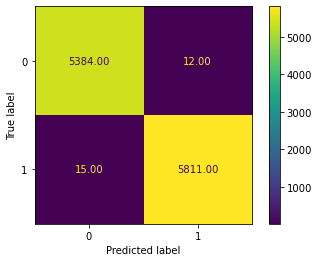

In [32]:
plot_confusion_matrix(pipe, X_test, y_test, values_format='.2f')

Still checking ROC AUC Score which as well is amazing.

In [33]:
auc = roc_auc_score(y_test, pipe.decision_function(X_test))
print("AUC score:\n", auc)

AUC score:
 0.9995905156125108


And some plots of:

-precision vs recall curve

-roc curve

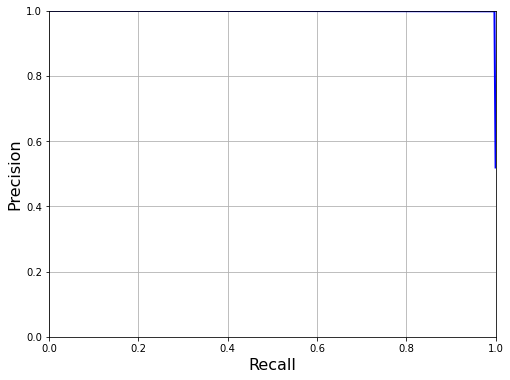

In [34]:
precisions, recalls, thresholds = precision_recall_curve(y_test, test_pred)
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

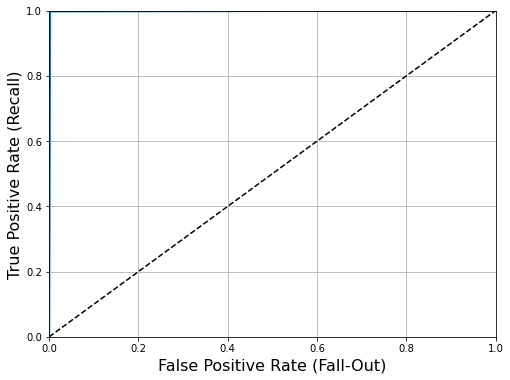

In [35]:
fpr, tpr, threshs = roc_curve(y_test, test_pred)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()